# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import numpy as np
from scipy import signal
import xarray as xr
from scipy.fft import fft, ifft

from src.utils.dataset_utils import *
from src.datasets.rb_fpa_full_quench_V2 import RBFPAFullQuench_V2
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_nmf_event_composition, plot_avg_component_weight, plot_component_distribution

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

from operator import eq

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/MP3_context_data/20230313_RB_processed.csv")
len(mp3_fpa_df)

4859

# Read Metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


# Load data

In [6]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20230313_RBFPAFullQuench_V2")

dataset_creator = RBFPAFullQuench_V2()

test_conditions = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) &
                   (mp3_fpa_df['Nr in Q event'].astype(str) != '1') &
                   (mp3_fpa_df['timestamp_fgc'] >= 1526582397220000000))

fpa_identifiers = mp3_fpa_df[~test_conditions].fpa_identifier.unique()

ds = dataset_creator.load_dataset(fpa_identifiers=fpa_identifiers,
                                  dataset_path=dataset_path,
                                 location={'time':slice(0.25, 0.55)})

# Choose quenched magnet signal

In [7]:
fpa_identifiers_full = fpa_identifiers[np.isin(fpa_identifiers, ds.event.values)]
mp3_fpa_df_unique = mp3_fpa_df[mp3_fpa_df.fpa_identifier.isin(fpa_identifiers_full)].drop_duplicates(subset=['fpa_identifier'])

In [8]:
q_pos = mp3_fpa_df_unique['#Electric_circuit'].values - 1
bool_q = np.full(ds.data.values.shape[:-1], False) 

for i, f in enumerate(fpa_identifiers_full):
    bool_q[i, q_pos[i]] = True

# define quench data 
da_q = xr.DataArray(data=ds.data.values[bool_q],
                    dims=["event", "time"])
da_q['time'] = ds.time
da_q['event'] = ds.event

# filter events with wrong alignment
event_max = np.nanmax(da_q.data, axis=1)
fpa_filtered = fpa_identifiers_full[event_max < 3]
da_q = da_q[event_max < 3]

# subtract mean
da_q_detrend = dataset_creator.detrend_dim(da_q.to_dataset(name='data'), deg=1).data

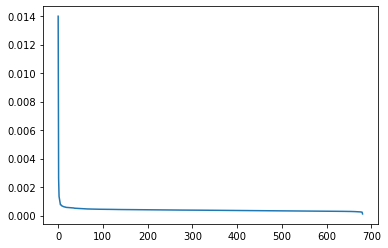

In [12]:
# calculate FFT
f_window=np.hanning
f_lim=(200, 500)
#f_lim=(20, 500)

da_q_fft = get_fft_of_DataArray(data=da_q_detrend, f_window=f_window)
f_range_bool = (da_q_fft.frequency > f_lim[0]) & (da_q_fft.frequency < f_lim[1])
da_q_fft = da_q_fft[:, f_range_bool]
da_q_fft_amplitude = scale_fft_amplitude(data=da_q_fft, f_window=f_window)

# look for outliers
event_mean = np.nanmax(da_q_fft_amplitude, axis=1)
indx_outlier = np.argsort(event_mean)[::-1]
plt.plot(event_mean[indx_outlier])

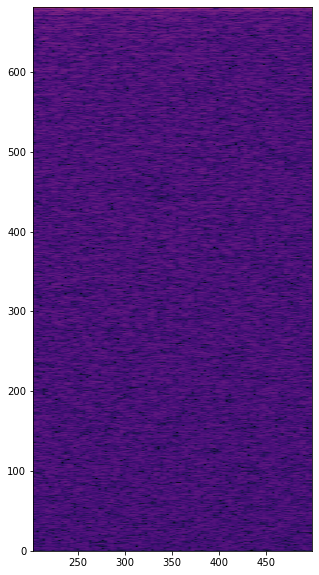

In [13]:
fig, ax = plt.subplots(figsize=(5, 10))
extent=[da_q_fft_amplitude.frequency.min(), da_q_fft_amplitude.frequency.max(),0, len(da_q_fft_amplitude)]

im = ax.imshow(da_q_fft_amplitude.data[indx_outlier], extent=extent, cmap="magma", origin="upper", aspect="auto", norm=colors.LogNorm(1e-5,1))

RB_RB.A34_1618896510960000000
RB_RB.A12_1621014819920000000
RB_RB.A78_1619330143440000000
RB_RB.A45_1620326712740000000
RB_RB.A45_1620797547820000000
RB_RB.A34_1618778711460000000
RB_RB.A45_1621148585120000000
RB_RB.A23_1648021135060000000
RB_RB.A34_1619850501280000000
RB_RB.A45_1622226069560000000


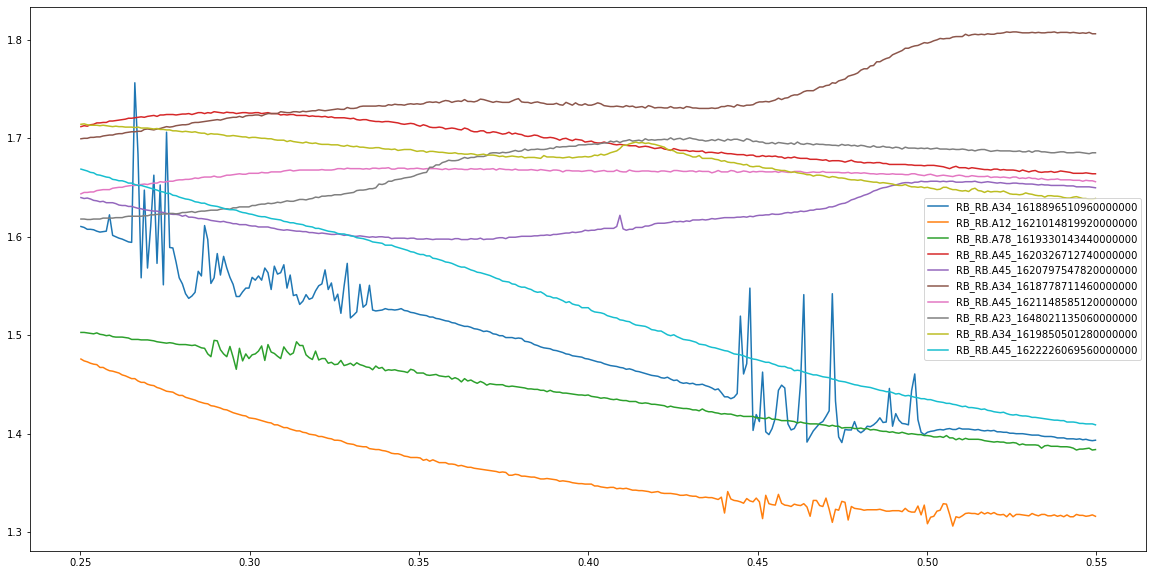

In [14]:
n_outliers = 10

plt.figure(figsize=(20, 10))
for i in indx_outlier[:n_outliers]:
    print(da_q[i].event.values)
    plt.plot(ds.time, da_q[i].T, label = da_q[i].event.values)
plt.legend()
plt.show()
